# Package installations and Import

In [1]:
!pip install openai
!pip install neo4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.5/196.5 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.15.0-py3-none-any.whl size=272484 sha256=c6e24f873336cfe0e74f850d5fcb6661172f9117ce9b2e

In [2]:
import json
import sys
import networkx as nx
import matplotlib.pyplot as plt

import os
import requests
import gzip
import shutil
import openai

from neo4j import GraphDatabase

# Set Up OpenAI API Key

In [5]:
import os
import getpass
name = 'OPENAI_API_KEY'
secret = getpass.getpass("Enter the OpenAI API Key")
os.environ[name] = secret
print(f"Have successfully set up {name} as an environment variable.")

Have successfully set up OPENAI_API_KEY as an environment variable.


In [6]:
# Define your API key (keep it secret!)
openai.api_key = os.environ[name]
API_KEY = os.environ[name]

In [7]:
#import openai
from openai import OpenAI

client = OpenAI()

# Connect to Graph DB

In [8]:
# Connect to the Neo4j database
uri=#Enter URI
username=#Enter username
password=#Enter password

# Create a Neo4j driver
driver = GraphDatabase.driver(uri, auth=(username, password))

# Final Model

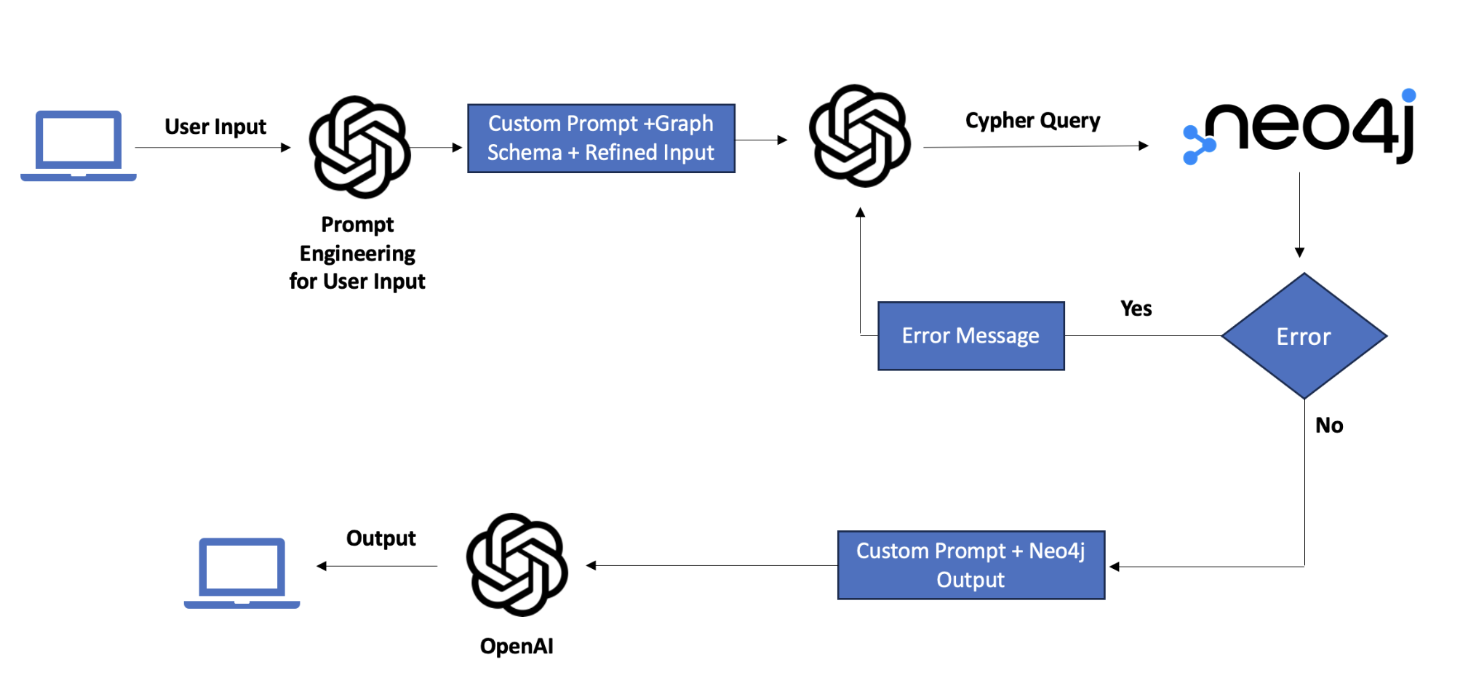

## Refine Prompt

In [9]:
def refine_prompt(raw_prompt, openai_api_key=os.environ['OPENAI_API_KEY']):
    """
    Refines a raw user input using OpenAI's language model to create a more effective prompt.

    Parameters:
    raw_prompt (str): The original user input.
    openai_api_key (str): Your OpenAI API key.

    Returns:
    dict: A dictionary containing the status ('success' or 'failed') and the refined prompt.
    """
    try:
        openai.api_key = openai_api_key

        # Constructing the prompt for the LLM to refine the user input
        prompt_to_refine = (
            "The following is a plain English user input for querying a graph database: '{}'. "
            "Rewrite this input into a clearer query format. "
            "However, do not remove any information related to the database or information related to node type which the user provided. If the input is not clear or relevant, indicate that the user should provide a clearer query. "
            "Do not remove any information related to database and node attributes."
            "For example, if the input is 'I want to know how many nodes are in this database', "
            "a better format would be 'Find the number of nodes in the database'.\n"
            "Refined Input: ".format(raw_prompt)
        )

        max_tokens = 100
        if len(raw_prompt.split()) > 100:
            max_tokens = len(raw_prompt.split())

        # response = openai.Completion.create(
        #     engine="text-davinci-003",  # Use the latest available engine
        #     prompt=prompt_to_refine,
        #     max_tokens=max_tokens  # Adjust based on your needs
        # )
        response = client.completions.create(
            model="text-davinci-003",  # Use the latest available engine
            prompt=prompt_to_refine,
            max_tokens=max_tokens  # Adjust based on your needs
        )

        refined_prompt = response.choices[0].text.strip()


        # Check if the refined prompt is valid
        if "provide a clearer query" in refined_prompt.lower():
            return {"status": "failed", "updated_user_prompt": refined_prompt}
        else:
            return {"status": "success", "updated_user_prompt": refined_prompt}
    except Exception as e:
        print(f"Error in refining prompt: {e}")
        return {"status": "failed", "updated_user_prompt": raw_prompt}



## LLM with Error Looping mechanism

In [10]:
import openai
import re

from typing import Any, Dict, List, Optional

def neo4j_query(query: str, params: dict = {}) -> List[Dict[str, Any]]:

    """Query Neo4j database."""
    from neo4j.exceptions import CypherSyntaxError

    with driver.session(database="neo4j") as session:
        try:
            data = session.run(query, params)
            return [r.data() for r in data]
        except CypherSyntaxError as e:
            raise ValueError(f"Generated Cypher Statement is not valid\n{e}")

def refresh_schema() -> str:
    """
    Refreshes the Neo4j graph schema information.
    """


    node_properties_query = """
    CALL apoc.meta.data()
    YIELD label, other, elementType, type, property
    WHERE NOT type = "RELATIONSHIP" AND elementType = "node"
    WITH label AS nodeLabels, collect({property:property, type:type}) AS properties
    RETURN {labels: nodeLabels, properties: properties} AS output

    """

    rel_properties_query = """
    CALL apoc.meta.data()
    YIELD label, other, elementType, type, property
    WHERE NOT type = "RELATIONSHIP" AND elementType = "relationship"
    WITH label AS nodeLabels, collect({property:property, type:type}) AS properties
    RETURN {type: nodeLabels, properties: properties} AS output
    """

    rel_query = """
    CALL apoc.meta.data()
    YIELD label, other, elementType, type, property
    WHERE type = "RELATIONSHIP" AND elementType = "node"
    UNWIND other AS other_node
    RETURN {start: label, type: property, end: toString(other_node)} AS output
    """


    node_properties = [el["output"] for el in neo4j_query(node_properties_query)]
    rel_properties = [el["output"] for el in neo4j_query(rel_properties_query)]
    relationships = [el["output"] for el in neo4j_query(rel_query)]

    structured_schema = {
        "node_props": {el["labels"]: el["properties"] for el in node_properties},
        "rel_props": {el["type"]: el["properties"] for el in rel_properties},
        "relationships": relationships,
    }
    schema_str = f"""
    Node properties are the following:
    {node_properties}
    Relationship properties are the following:
    {rel_properties}
    The relationships are the following:
    {[f"(:{el['start']})-[:{el['type']}]->(:{el['end']})" for el in relationships]}
    """

    return schema_str

def get_gpt3_response(curr_schema, question, api_key, model="gpt-3.5-turbo",history=None):
    """
    Send a request to the OpenAI Chat API and get a response from the model.

    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".

    Returns:
        str: The model's response.
    """




    system_prompt =  """

    "Human: Task:Generate Cypher statement to query a graph database.\nInstructions:\nUse only the provided
    relationship types and properties in the schema.\nDo not use any other relationship types or
    properties that are not provided.\n
    Consider directionality of the graph.\n
    The cypher output should have some indication either as variable name to indicate the requirement of the
    question.\n
    Do not include any explanations or apologies in your responses.\n
    Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
    \nSchema:
    {}".
    """.format(curr_schema)

    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

    if history:
        messages.extend(history)

    ## Use the OpenAI Python client to send the request
    response = client.chat.completions.create(
        model=model,
        messages=messages
    )

    # Extract the response text and return
    return response.choices[0].message.content
    #return response.choices[0].message['content']


def get_gpt3_response_2(prompt, question, api_key, model="gpt-3.5-turbo",history=None):
    """
    Send a request to the OpenAI Chat API and get a response from the model.

    Args:
        prompt (str): The user's question.
        context (str): Contextual information to be passed to the model.
        api_key (str): Your OpenAI API key.
        model (str): The model version to use, default is "gpt-3.5-turbo".

    Returns:
        str: The model's response.
    """



    system_prompt =  """

    "Human: You are an assistant that helps to form nice and human understandable answers
    .\nThe information part contains the provided information that you must use to construct an answer.
    \nThe provided information is authoritative, you must never doubt it or try to use your internal knowledge
    to correct it.\nMake the answer sound as a response to the question.
    Do not mention that you based the result on the given information.\n
    Only If the information is empty then return whatever asked in the question does not exist\n
    Output only the node ids to represent the nodes, unless specified
    \nInformation:\n{}"
    """.format(prompt)

    # Create the full prompt by combining the system prompt, context, and the user question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

    if history:
        messages.extend(history)

    ## Use the OpenAI Python client to send the request
    response = client.chat.completions.create(
        model=model,
        messages=messages
    )

    # Extract the response text and return
    return response.choices[0].message.content




def lang_chain_custom(question,driver,model="gpt-3.5-turbo"):

    curr_schema = refresh_schema()

    ## Getting Cypher query
    response = get_gpt3_response(curr_schema, question,  API_KEY, model)
    print('Cypher Query is',response)
    print('\n')

    ## Interacting with neo4j
    try:
        cypher_response = neo4j_query(response)
        cypher_response = cypher_response[:10] ## Limiting it to avoid token limits
        print('Neo4j answer is',cypher_response)
        print('\n')

    except Exception as e:

        #print(str(e))
        try:
            print('Retrying')
            print(str(e))

            history = [
                    {"role": "assistant", "content": response},
                    {
                        "role": "user",
                        "content": f"""This query returns an error: {str(e)}
                        Give me a improved query that works without any explanations or apologies""",
                    },

            ]
            #print(history)
            response = get_gpt3_response(curr_schema, question,  API_KEY, model,history)
            print('New Cypher Query is',response)
            print('\n')

            cypher_response = neo4j_query(response)
            cypher_response = cypher_response[:10] ## Limiting it to avoid token limits
            print('Neo4j answer is',cypher_response)
            print('\n')

        except Exception as e:
            cypher_response = []

    ## Obtaining final answer
    response_2 = get_gpt3_response_2(cypher_response, question,  API_KEY, model)
    pattern = r'\bsorry\b'
    # re.IGNORECASE flag makes the search case-insensitive
    if(bool(re.search(pattern, response_2, re.IGNORECASE))):

        print('Retrying output string')

        history = [
        {"role": "assistant", "content": response_2},
        {
            "role": "user",
            "content": f"""This query returns an incomplete answer.
            If the information is empty then return does not exist or unknown.\n
            If not, assume the output is a simplified answer to
            the question {question}
            Give me a improved query that works without any explanations or apologies""",
        },

        ]

        response_2 = get_gpt3_response_2(cypher_response, question,  API_KEY, model,history)

    return response_2

# Results

## Number of nodes

In [ ]:
question = """
How many nodes are there of type Node_201511060000
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the number of nodes of type Node_201511060000 in the graph database.
-----
Cypher Query is MATCH (n:Node_201511060000) RETURN count(n) AS NumberOfNodes


Neo4j answer is [{'NumberOfNodes': 78}]


The graph database does not contain any nodes of type Node_201511060000.


In [ ]:
question = """
How many nodes are there of type Node_201511060800
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the number of nodes in the database with type Node_201511060800.
-----
Cypher Query is MATCH (n:Node_201511060800) RETURN COUNT(n) AS NumberOfNodes


Neo4j answer is [{'NumberOfNodes': 78}]


Retrying output string
There are no nodes of the type Node_201511060800 in the database.


## Number of edges

In [ ]:
question = """
How many edges are there between the nodes with type Node_201511060000
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the number of edges between the nodes of type Node_201511060000.
-----
Cypher Query is MATCH (n:Node_201511060000)-[:CONNECTS_201511060000]->(m:Node_201511060000)
RETURN COUNT(*) AS NumberOfEdges


Neo4j answer is [{'NumberOfEdges': 139}]


There are 139 edges between the nodes of type Node_201511060000.


In [ ]:
question = """
How many edges are there between the nodes with type Node_201511060800
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the number of edges between the nodes with type Node_201511060800.
-----
Cypher Query is MATCH (n:Node_201511060800)-[r:CONNECTS_201511060800]->(m:Node_201511060800) RETURN COUNT(r) AS NumberOfEdges


Neo4j answer is [{'NumberOfEdges': 140}]


There are 140 edges between the nodes with type Node_201511060800.


## Path Length

T1

In [ ]:
# 22804, 48479 and 28625
question = """
What are the paths from node 22804 to node 28625 for nodes of type Node_201511060000? Also, return the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the paths from node 22804 to node 28625 with node type 'Node_201511060000' and return the length of each path.
-----
Cypher Query is MATCH path = (start:Node_201511060000{id:'22804'})-[:CONNECTS_201511060000*]->(end:Node_201511060000{id:'28625'}) 
RETURN path, length(path) AS path_length


Neo4j answer is []


Retrying output string
The paths from node 22804 to node 28625 with node type 'Node_201511060000' do not exist.


In [ ]:
question = """
What are the paths from node 22804 to node 48479 for nodes of type Node_201511060000? Also, return the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the paths from Node 22804 to Node 48479 for nodes of type Node_201511060000 and return the path length of each path.
-----
Cypher Query is MATCH path = (node1:Node_201511060000{id:'22804'})-[:CONNECTS_201511060000*]->(node2:Node_201511060000{id:'48479'})
RETURN path as Paths, length(path) as PathLength


Neo4j answer is []


Whatever you asked in the question does not exist.


In [ ]:
question = """
What are the paths from node 48479 to node 28625 for nodes of type Node_201511060000? Also, return the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find all paths from node 48479 to node 28625 with nodes of type Node_201511060000, along with the length of each path.
-----
Cypher Query is MATCH path = (start:Node_201511060000 {id:"48479"})-[:CONNECTS_201511060000*]->(end:Node_201511060000 {id:"28625"})
RETURN path, length(path) as pathLength


Neo4j answer is []


Retrying output string
The paths from node 48479 to node 28625 with nodes of type Node_201511060000 do not exist.


In [ ]:
question = """
What are the paths from node 1251 to node 4844 for nodes of type Node_201511060000?
Also, return each path and the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find all the paths from node 1251 to node 4844 that include only nodes of type Node_201511060000, and return each path and its respective path length.
-----
Cypher Query is MATCH path=(start:Node_201511060000)-[:CONNECTS_201511060000*]->(end:Node_201511060000)
WHERE start.id = '1251' AND end.id = '4844'
RETURN path, length(path) AS path_length


Neo4j answer is [{'path': [{'id': '1251'}, 'CONNECTS_201511060000', {'id': '28625'}, 'CONNECTS_201511060000', {'country': 'US', 'id': '12989', 'org_name': 'StackPath LLC', 'as_name': 'StackPath'}, 'CONNECTS_201511060000', {'upstream': '8', 'downstream': '539', 'rank': '2276', 'id': '6762', 'as_name': 'SEABONE-NET'}, 'CONNECTS_201511060000', {'country': 'US', 'upstream': '25', 'city': 'Monroe', 'downstream': '5283', 'rank': '15', 'id': '3356', 'state': 'LA', 'org_name': 'Level 3 Parent, LLC', 'as_name': 'LEVEL3'}, 'CONNECTS_201511060000', {'country': 'US', 'upstream': '18', 'city': 'Redmond', 'downstream': '1210', 'rank': '108', 'id': '2914', 's

T2

In [ ]:
question = """
What are the paths from node 22804 to node 28625 for nodes of type Node_201511060800? Also, return each path and the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the paths from node 22804 to node 28625 for nodes of type Node_201511060800, then return each path and the path length of each path.
-----
Cypher Query is MATCH p = (start:Node_201511060800 {id: '22804'})-[:CONNECTS_201511060800*..]->(end:Node_201511060800 {id: '28625'}) 
RETURN p, length(p) AS path_length


Neo4j answer is []


Retrying output string
The paths from node 22804 to node 28625 for nodes of type Node_201511060800 do not exist.


In [ ]:
# 22804, 48479 and 28625
question = """
What are the paths from node 48479 to node 28625 for nodes of type Node_201511060800? Also, return the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the paths from node 48479 to node 28625, where the intermediate nodes are of type Node_201511060800, and return the path length of each path.
-----
Cypher Query is MATCH p=(start:Node_201511060800{id: '48479'})-[:CONNECTS_201511060800*]->(end:Node_201511060800{id: '28625'})
RETURN p AS path, length(p) AS path_length


Neo4j answer is []


Retrying output string
The paths from node 48479 to node 28625 where the intermediate nodes are of type Node_201511060800 do not exist.


In [ ]:
# 22804, 48479 and 28625
question = """
What are the paths from node 48479 to node 28625 for nodes of type Node_201511060800? Also, return the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find all paths from Node 48479 to Node 28625 of Node_201511060800 type, and return the paths' length for each path.
-----
Cypher Query is MATCH path = (start:Node_201511060800 {id:"48479"}) - [:CONNECTS_201511060800*] -> (end:Node_201511060800 {id:"28625"}) 
RETURN path, length(path) AS pathLength


Neo4j answer is []


Whatever asked in the question does not exist.


In [ ]:
# 22804, 48479 and 28625
question = """
What are the paths from node 1251 to node 4844 for nodes of type Node_201511060800? Also, return each path and the path length of each path
"""
question = refine_prompt(question)["updated_user_prompt"]
print(question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Find the paths (including path length) from Node 1251 to Node 4844, with the nodes along the paths belonging to type Node_201511060800.
-----
Cypher Query is MATCH path = (a:Node_201511060800 {id: '1251'})-[:CONNECTS_201511060800*]->(b:Node_201511060800 {id: '4844'})
RETURN path, length(path) AS path_length


Neo4j answer is [{'path': [{'id': '1251'}, 'CONNECTS_201511060800', {'id': '28625'}, 'CONNECTS_201511060800', {'country': 'US', 'id': '12989', 'org_name': 'StackPath LLC', 'as_name': 'StackPath'}, 'CONNECTS_201511060800', {'upstream': '8', 'downstream': '539', 'rank': '2276', 'id': '6762', 'as_name': 'SEABONE-NET'}, 'CONNECTS_201511060800', {'country': 'US', 'upstream': '18', 'city': 'Redmond', 'downstream': '1210', 'rank': '108', 'id': '2914', 'state': 'WA', 'org_name': 'NTT America, Inc.', 'as_name': 'NTT-LTD-2914'}, 'CONNECTS_201511060800', {'country': 'AU', 'upstream': '3', 'downstream': '2', 'rank': '11551', 'id': '4844', 'org_name': 'SuperInternet Access Pte Ltd', 'as_name':

## Path Existence

In [ ]:
question = """
Does a path exist from node 28625 to node 2828 for nodes of type node_201511060000? If so what is the path in terms of node id?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the path from node 28625 to node 2828, where the nodes are of type node_201511060000.
-----
Cypher Query is MATCH path=(n:Node_201511060000 {id: "28625"})-[:CONNECTS_201511060000*]->(m:Node_201511060000 {id: "2828"})
RETURN path


Neo4j answer is [{'path': [{'id': '28625'}, 'CONNECTS_201511060000', {'country': 'US', 'upstream': '1', 'city': 'Ashburn', 'downstream': '0', 'rank': '58258', 'id': '23148', 'state': 'VA', 'org_name': 'Verizon Business', 'as_name': 'TERRENAP'}, 'CONNECTS_201511060000', {'country': 'US', 'upstream': '4', 'city': 'Ashburn', 'downstream': '177', 'rank': '112', 'id': '2828', 'state': 'VA', 'org_name': 'Verizon Business', 'as_name': 'XO-AS15'}]}]


The path from node 28625 to node 2828 is as follows: Node 28625 connects to node 23148, which in turn connects to node 2828. All nodes are of type node_201511060000.


In [ ]:
question = """
Does a path exist from node 28625 to node 52619 for nodes of type node_201511060000? If so what is the path in terms of node id?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the path from node 28625 to node 52619 for nodes of type node_201511060000, in terms of node id.
-----


ERROR:neo4j:Failed to read from defunct connection IPv4Address(('28e5b287.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))


Cypher Query is MATCH path=(start:Node_201511060000{id:'28625'})-[:CONNECTS_201511060000*]->(end:Node_201511060000{id:'52619'})
RETURN path


Retrying
Failed to read from defunct connection IPv4Address(('28e5b287.databases.neo4j.io', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))


ERROR:neo4j:Failed to read from defunct connection ResolvedIPv4Address(('34.66.78.163', 7687)) (ResolvedIPv4Address(('34.66.78.163', 7687)))
ERROR:neo4j:Unable to retrieve routing information


New Cypher Query is MATCH (start:Node_201511060000{id:'28625'}), (end:Node_201511060000{id:'52619'})
CALL algo.shortestPath.stream(start, end, 'weight')
YIELD nodeId, cost
RETURN algo.getNodeById(nodeId).id AS NodeId, cost


Whatever asked in the question does not exist.


## Change in path

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, have the paths from node 28625 to node 4608 changed? If so, how did it change?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the paths between node 28625 and 4608 at time t1 (using node type Node_201511060000 and relationship CONNECTS_201511060000) and time t2 (using node type Node_201511060800 and relationship CONNECTS_201511060800). Have there been any changes between the two timestamps and if so, specify the changes.
-----
Cypher Query is MATCH path_t1 = (n1:Node_201511060000 {id: '28625'})-[:CONNECTS_201511060000*..]->(n2:Node_201511060000 {id: '4608'})
MATCH path_t2 = (n3:Node_201511060800 {id: '28625'})-[:CONNECTS_201511060800*..]->(n4:Node_201511060800 {id: '4608'})
RETURN path_t1, path_t2, path_t1 <> path_t2 AS change_detected


Neo4j answer is [{'path_t1': [{'id': '28625'}, 'CONNECTS_201511060000', {'country': 'US', 'id': '12989', 'org_name': 'StackPath LLC', 'as_name': 'StackPath'}, 'CONNECTS_201511060000', {'country': 'AU', 'upstream': '10', 'downstream': '445', 'rank': '551', 'id': '4637', 'org_name': 'Telstra International Limited', 'as_name': 'ASN-TELSTRA-GLOBAL'}, 'CON

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, have the paths from node 204016 to node 48479 changed? If so, how did it change?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the changes in the paths from node 204016 to 48479 in the graph with nodes of type Node_201511060000 and relationship CONNECTS_201511060000 at time t1 and nodes of type Node_201511060800 and relationship CONNECTS_201511060800 at time t2.
-----
Cypher Query is MATCH path_t1 = (n1:Node_201511060000{ id: '204016' })-[:CONNECTS_201511060000*]->(n2:Node_201511060000{ id: '48479' })
MATCH path_t2 = (n3:Node_201511060800{ id: '204016' })-[:CONNECTS_201511060800*]->(n4:Node_201511060800{ id: '48479' })
RETURN path_t1 as path_at_t1, path_t2 as path_at_t2


Neo4j answer is [{'path_at_t1': [{'country': 'AZ', 'upstream': '1', 'downstream': '0', 'rank': '69109', 'id': '204016', 'org_name': 'International Bank of Azerbaijan OJSC', 'as_name': 'ABBBank'}, 'CONNECTS_201511060000', {'country': 'RU', 'upstream': '2', 'downstream': '0', 'rank': '23135', 'id': '49478', 'org_name': 'Provodov.net Ltd.', 'as_name': 'PROVODOV_NET-AS'}, 'CONNECTS_201511060000', {'country': 'RU', 'upstre

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, have the shortest paths from node 28625 to node 2497 changed? If so, how did it change?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the shortest paths from node 28625 to node 2497 in the graph with Node_201511060000 and CONNECTS_201511060000 relationship elements at t1, and Node_201511060800 and CONNECTS_201511060800 relationship elements at t2. Determine if the shortest path between node 28625 and node 2497 has changed between t1 and t2, and how it has changed if so.
-----
Cypher Query is MATCH p1=shortestPath((a:Node_201511060000 {id:"28625"})-[:CONNECTS_201511060000*]-(b:Node_201511060000 {id: "2497"}))
MATCH p2=shortestPath((c:Node_201511060800 {id:"28625"})-[:CONNECTS_201511060800*]-(d:Node_201511060800 {id: "2497"}))
RETURN p1, p2, LENGTH(p1) = LENGTH(p2) as pathLengthUnchanged, CASE WHEN LENGTH(p1) = LENGTH(p2) THEN NULL ELSE LENGTH(p2) - LENGTH(p1) END as pathLengthDifference


Neo4j answer is [{'p1': [{'id': '28625'}, 'CONNECTS_201511060000', {'country': 'US', 'upstream': '1', 'city': 'Ashburn', 'downstream': '0', 'rank': '58258', 'id': '23148', 'state': 'VA', 'org_name': 'Verizon 

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, have the shortest paths from node 31133 to node 4777 changed? If so, how did it change?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the shortest path from node 31133 to node 4777 of the graph with node type Node_201511060000 and relationship CONNECTS_201511060000 at time t1, and compare it to the shortest path from node 31133 to node 4777 of the graph with node type Node_201511060800 and relationship CONNECTS_201511060800 at time t2. Have the shortest paths changed between t1 and t2, and if
-----
Cypher Query is MATCH (a:Node_201511060000{id:"31133"}), (b:Node_201511060000{id:"4777"}), p=shortestPath((a)-[:CONNECTS_201511060000*..15]->(b))
WITH p as path_t1
MATCH (c:Node_201511060800{id:"31133"}), (d:Node_201511060800{id:"4777"}), p=shortestPath((c)-[:CONNECTS_201511060800*..15]->(d))
WITH path_t1, p as path_t2
RETURN path_t1, path_t2, CASE WHEN path_t1 = path_t2 THEN FALSE ELSE TRUE END AS hasChanged


Neo4j answer is [{'path_t1': [{'upstream': '8', 'downstream': '459', 'rank': '468', 'id': '31133', 'as_name': 'MF-MGSM-AS'}, 'CONNECTS_201511060000', {'country': 'US', 'upstream': '25', 'cit

## Change in number of Paths

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, are there any change in number of paths from node 28625 to node 50300?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the number of paths from node 28625 to node 50300 between graph t1 (defined by node type Node_201511060000 and relationship CONNECTS_201511060000) and graph t2 (defined by node type Node_201511060800 and relationship CONNECTS_201511060800) and compare the number of paths between the two graphs.
-----
Cypher Query is MATCH p1=(n1:Node_201511060000 {id: '28625'})-[:CONNECTS_201511060000*]->(m1:Node_201511060000 {id: '50300'})
WITH count(p1) as t1_paths
MATCH p2=(n2:Node_201511060800 {id: '28625'})-[:CONNECTS_201511060800*]->(m2:Node_201511060800 {id: '50300'})
RETURN t1_paths as Total_Paths_in_T1, count(p2) as Total_Paths_in_T2


Neo4j answer is [{'Total_Paths_in_T1': 9, 'Total_Paths_in_T2': 7}]


In graph t1, defined by node type Node_201511060000 and relationship CONNECTS_201511060000, there are a total of 9 paths from node 28625 to node 50300. Meanwhile, in graph t2, defined by node type Node_201511060800 and relationship CONNECTS_201511060800, there are a tot

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, are there any change in number of paths from node 2906 to node 29608?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the difference in the number of paths between nodes 2906 and 29608 from the graph at time t1 (with nodes of type Node_201511060000 and the relationship CONNECTS_201511060000) and the graph at time t2 (with nodes of type Node_201511060800 and the relationship CONNECTS_201511060800).
-----
Cypher Query is MATCH p1=(n1:Node_201511060000{id:'2906'})-[:CONNECTS_201511060000*]->(m1:Node_201511060000{id:'29608'}),
      p2=(n2:Node_201511060800{id:'2906'})-[:CONNECTS_201511060800*]->(m2:Node_201511060800{id:'29608'})
RETURN abs(size(p1) - size(p2)) AS DifferenceInPathCount


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Type mismatch: expected String or List<T> but was Path (line 3, column 17 (offset: 227))
"RETURN abs(size(p1) - size(p2)) AS DifferenceInPathCount"
                 ^}
New Cypher Query is MATCH (n1:Node_201511060000{id:'2906'}), (m1:Node_201511060000{id:'29608'}),
      (n2:Node_201511060800{id

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, are there any change in number of paths from node 2906 to node 29608?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find out if there are any changes in the number of paths from node 2906 to node 29608 between graphs with node type Node_201511060000 and the relationship CONNECTS_201511060000 at time t1, and node type Node_201511060800 and the relationship CONNECTS_201511060800 at time t2.
-----
Cypher Query is MATCH p_t1=(n1:Node_201511060000{id:'2906'})-[:CONNECTS_201511060000*]->(n2:Node_201511060000{id:'29608'})
RETURN count(p_t1) as Paths_t1

MATCH p_t2=(n1:Node_201511060800{id:'2906'})-[:CONNECTS_201511060800*]->(n2:Node_201511060800{id:'29608'})
RETURN count(p_t2) as Paths_t2


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: RETURN can only be used at the end of the query (line 2, column 1 (offset: 107))
"RETURN count(p_t1) as Paths_t1"
 ^}
New Cypher Query is MATCH p_t1=(n1:Node_201511060000{id:'2906'})-[:CONNECTS_201511060000*]->(n2:Node_201511060000{id:'29608'})
WITH count(p_t1) as Paths_t1
MATCH p_t2=(n1:Node_2015

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, are there any change in number of paths from node 1251 to node 4844?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the number of paths from node 1251 to node 4844 with Node_201511060000 as source and CONNECTS_201511060000 as relationship type at time t1 and Node_201511060800 as source and CONNECTS_201511060800 as relationship type at time t2 and compare the number of paths between t1 and t2.
-----
Cypher Query is MATCH path_t1=(n1:Node_201511060000{id:'1251'})-[:CONNECTS_201511060000*]->(n2:Node_201511060000{id:'4844'})
WITH count(path_t1) AS num_paths_t1
MATCH path_t2=(n3:Node_201511060800{id:'1251'})-[:CONNECTS_201511060800*]->(n4:Node_201511060800{id:'4844'})
RETURN num_paths_t1 AS number_of_paths_at_t1, count(path_t2) AS number_of_paths_at_t2


Neo4j answer is [{'number_of_paths_at_t1': 6, 'number_of_paths_at_t2': 5}]


At time t1, while taking Node_201511060000 as a source and CONNECTS_201511060000 as a relationship type, there were 6 paths from node 1251 to node 4844. However, at time t2, with Node_201511060800 as a source and CONNECTS_201511060800 as a relationship t

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph G1.
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph G2.
Between G1 and G2, are there any change in number of paths from node 1251 to node 4844?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the difference in the number of paths between graph G1, which consists of the nodes of type Node_201511060000 and the relationship CONNECTS_201511060000, and graph G2, which consists of the nodes of type Node_201511060800 and the relationship CONNECTS_201511060800, from node 1251 to node 4844.
-----
Cypher Query is MATCH path1 = (n1:Node_201511060000 {id: '1251'})-[:CONNECTS_201511060000*..]->(m1:Node_201511060000 {id: '4844'})
WITH count(path1) as G1_paths
MATCH path2 = (n2:Node_201511060800 {id: '1251'})-[:CONNECTS_201511060800*..]->(m2:Node_201511060800 {id: '4844'})
RETURN G1_paths - count(path2) as path_diff


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Aggregation column contains implicit grouping expressions. For example, in 'RETURN n.a, n.a + n.b + count(*)' the aggregation expression 'n.a + n.b + count(*)' includes the implicit grouping key 'n.b'. It may be possible to rewrite the query by ex

## Difference in Shortest and Current path

In [ ]:
question = """
If the current path from 1251 to 4844 is 1251-28625-12989-6762-3356-2914-4844 for node type Node_201511060000,
is it differnt from the shortest path possible?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find out if the current path from 1251 to 4844 (1251-28625-12989-6762-3356-2914-4844) for Node_201511060000 is different from the shortest path possible.
-----
Cypher Query is MATCH p=(n1:Node_201511060000 {id:"1251"})-[:CONNECTS_201511060000*]->(n2:Node_201511060000 {id: "4844"})
WHERE ALL(node IN nodes(p) WHERE node.id IN ["1251","28625","12989","6762","3356","2914","4844"])
WITH p, length(p) AS currentPathLength
MATCH sp=shortestPath((n1:Node_201511060000 {id:"1251"})-[:CONNECTS_201511060000*]->(n2:Node_201511060000 {id:"4844"}))
WITH sp, length(sp) AS shortestPathLength, currentPathLength
RETURN CASE 
         WHEN shortestPathLength < currentPathLength THEN sp 
         ELSE p
       END AS path, currentPathLength = shortestPathLength AS isPathShortest


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Variable `p` not defined (line 8, column 15 (offset: 513))
"         ELSE p"
               ^}
New Cypher

In [ ]:
question = """
If the current path from 1251 to 4844 is 1251-28625-12989-6762-3356-2914-4844 for node type Node_201511060000,
What is the shortest path possible and what is the difference?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the shortest path possible from Node_201511060000 1251 to 4844, and determine the difference between this path and the current path: 1251-28625-12989-6762-3356-2914-4844.
-----
Cypher Query is MATCH (startNode:Node_201511060000 { id: '1251' }),(endNode:Node_201511060000 { id: '4844' }),
path = shortestPath((startNode)-[:CONNECTS_201511060000*]-(endNode))
RETURN path as ShortestPath, length(path) as ShortestPathLength

MATCH currentPath=(s:Node_201511060000 {id:'1251'})-[:CONNECTS_201511060000*]->(n1:Node_201511060000 {id:'28625'})-[:CONNECTS_201511060000*]->(n2:Node_201511060000 {id:'12989'})-[:CONNECTS_201511060000*]->(n3:Node_201511060000 {id:'6762'})-[:CONNECTS_201511060000*]->(n4:Node_201511060000 {id:'3356'})-[:CONNECTS_201511060000*]->(n5:Node_201511060000 {id:'2914'})-[:CONNECTS_201511060000*]->(endNode:Node_201511060000 {id:'4844'})
RETURN length(currentPath) as CurrentPathLength

RETURN ShortestPathLength - CurrentPathLength as DifferenceInPathLength



In [ ]:
question = """
If the current path from 28625 to 50300 is 28625-12989-6762-3356-2914-50300 for node type Node_201511060000,
What is the shortest path possible and what is the difference?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the shortest path from Node_201511060000 at 28625 to 50300 and find the difference between the current path of 28625-12989-6762-3356-2914-50300 and the shortest path.
-----
Cypher Query is MATCH path=shortestPath((n1:Node_201511060000 {id: '28625'})-[:CONNECTS_201511060000*..10]->(n2:Node_201511060000 {id: '50300'}))
WITH length(path) as shortestPathLength
MATCH path2=(n3:Node_201511060000 {id: '28625'})-[:CONNECTS_201511060000]->(n4:Node_201511060000 {id: '12989'})
-[:CONNECTS_201511060000]->(n5:Node_201511060000 {id: '6762'})
-[:CONNECTS_201511060000]->(n6:Node_201511060000 {id: '3356'})
-[:CONNECTS_201511060000]->(n7:Node_201511060000 {id: '2914'})
-[:CONNECTS_201511060000]->(n8:Node_201511060000 {id: '50300'})
RETURN length(path2) - shortestPathLength AS pathDifference


Neo4j answer is [{'pathDifference': 3}]


The difference between the current path and the shortest path from Node_201511060000 at 28625 to 50300 is 3.


## Isolated nodes

In [11]:
question = """
Are there any isolated nodes of type Node_201511060000 in the network? Can you name all?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find all isolated Node_201511060000 nodes in the network and list their names.
-----
Cypher Query is MATCH (n:Node_201511060000)
WHERE NOT (n)-[:CONNECTS_201511060000]-()
RETURN n.as_name AS IsolatedNodeNames


Neo4j answer is []


Whatever you asked in the question does not exist.


In [12]:
question = """
Are there any isolated nodes of type Node_201511060800 in the network? Can you mention their ids?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the ids of any isolated nodes of type Node_201511060800 in the network.
-----
Cypher Query is MATCH (n:Node_201511060800)
WHERE NOT (n)-[:CONNECTS_201511060800]-()
RETURN n.id AS IsolatedNodeId


Neo4j answer is []


Whatever you asked in the question does not exist.


## Indegree

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
What is the in degree of node 22804 at t1?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the in degree of node 22804 of Node_201511060000 connected by CONNECTS_201511060000 at time t1.
-----
Cypher Query is MATCH (n:Node_201511060000 {id: '22804'})<-[:CONNECTS_201511060000]-(connectedNode)
RETURN count(connectedNode) as inDegreeT1


Neo4j answer is [{'inDegreeT1': 0}]


The in degree of node 22804 of Node_201511060000 connected by CONNECTS_201511060000 at time t1 is 0.


In [ ]:
question = """
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
What is the in degree of node 22804 at t2?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the in degree of Node_201511060800 with id 22804 at time t2 using the CONNECTS_201511060800 relationship.
-----
Cypher Query is MATCH (n:Node_201511060800 {id:'22804'})<-[r:CONNECTS_201511060800]-()
RETURN COUNT(r) AS in_degree


Neo4j answer is [{'in_degree': 0}]


The in degree of Node_201511060800 with id 22804 at time t2 using the CONNECTS_201511060800 relationship is 0.


In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1
What is the in degree of node 48479 at t1?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the in degree of Node_201511060000 with identifier 48479 at time t1, considering CONNECTS_201511060000 relationship in the graph.
-----
Cypher Query is MATCH (n:Node_201511060000)<-[:CONNECTS_201511060000]-(connectedNodes) WHERE n.id = '48479' 
RETURN COUNT(connectedNodes) AS InDegree_At_T1


Neo4j answer is [{'InDegree_At_T1': 9}]


The in-degree of Node_201511060000 with identifier 48479 at time t1, considering the CONNECTS_201511060000 relationship, is 9.


In [ ]:
question = """
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2
What is the in degree of node 48479 at t2?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the in degree of node 48479 of node type Node_201511060800 connected by relationship CONNECTS_201511060800 at time t2.
-----
Cypher Query is MATCH (n:Node_201511060800)<-[:CONNECTS_201511060800]-(m)
WHERE n.id = '48479'
RETURN COUNT(m) AS InDegree_T2


Neo4j answer is [{'InDegree_T2': 10}]


The in-degree of node 48479 of node type Node_201511060800 connected by relationship CONNECTS_201511060800 at time t2 is 10.


In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1
What is the in degree of node 28625 at t1?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the in-degree of node 28625 of type Node_201511060000 which has relation CONNECTS_201511060000 at time t1.
-----
Cypher Query is MATCH (n:Node_201511060000 {id: '28625'})<-[:CONNECTS_201511060000]-(m) 
RETURN COUNT(m) AS InDegree_T1


Neo4j answer is [{'InDegree_T1': 16}]


The in-degree of node 28625 of type Node_201511060000 which has relation CONNECTS_201511060000 at time t1 is 16.


In [ ]:
question = """
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2
What is the in degree of node 28625 at t2?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the in degree of Node_201511060800 with node ID of 28625 in the graph at time t2 using the CONNECTS_201511060800 relationship.
-----
Cypher Query is MATCH (n:Node_201511060800)<-[:CONNECTS_201511060800]-() WHERE n.id = '28625' RETURN COUNT(*) AS In_Degree_T2


Neo4j answer is [{'In_Degree_T2': 16}]


The in-degree of Node_201511060800 with node ID of 28625 in the graph at time t2 using the CONNECTS_201511060800 relationship is 16.


## Outdegree

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1.
What is the outdegree of node 22804 at t1?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the outdegree of node 22804 of type Node_201511060000 connected by relationship CONNECTS_201511060000 at time t1.
-----
Cypher Query is MATCH (n:Node_201511060000 {id: '22804'})-[r:CONNECTS_201511060000]->() 
RETURN COUNT(r) AS Outdegree_t1


Neo4j answer is [{'Outdegree_t1': 1}]


The outdegree of node 22804 of type Node_201511060000 connected by relationship CONNECTS_201511060000 at time t1 is 1.


In [ ]:
question = """
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
What is the outdegree of node 22804 at t2?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the outdegree of node 22804 of node type Node_201511060800 in the CONNECTS_201511060800 graph at time t2.
-----
Cypher Query is MATCH (n:Node_201511060800 {id:"22804"})-[r:CONNECTS_201511060800]->()
RETURN COUNT(r) AS Outdegree_Node_22804_at_t2


Neo4j answer is [{'Outdegree_Node_22804_at_t2': 1}]


The outdegree of node 22804 of node type Node_201511060800 in the CONNECTS_201511060800 graph at time t2 is 1.


In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1
What is the outdegree of node 48479 at t1?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the outdegree of node with node_id 48479, of node type Node_201511060000, connected by relationship CONNECTS_201511060000 at time t1.
-----
Cypher Query is MATCH (n:Node_201511060000 {id: "48479"})-[r:CONNECTS_201511060000]->()
RETURN count(r) AS Outdegree_t1


Neo4j answer is [{'Outdegree_t1': 2}]


The outdegree of the node with node_id 48479, of node type Node_201511060000, connected by relationship CONNECTS_201511060000 at time t1 is 2.


In [ ]:
question = """
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2
What is the outdegree of node 48479 at t2?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the outdegree of node 48479, of node type Node_201511060800, with the relationship CONNECTS_201511060800, at t2.
-----
Cypher Query is MATCH (n:Node_201511060800{id:'48479'})-[r:CONNECTS_201511060800]->()
RETURN COUNT(r) AS OutdegreeAtT2


Neo4j answer is [{'OutdegreeAtT2': 2}]


The outdegree of node 48479, of node type Node_201511060800, with the relationship CONNECTS_201511060800, at t2 is 2.


In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1
What is the outdegree of node 28625 at t1?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the outdegree of node 28625 with node type Node_201511060000 and relationship CONNECTS_201511060000 at time t1.
-----
Cypher Query is MATCH (n:Node_201511060000 {id: "28625"})-[r:CONNECTS_201511060000]->()
RETURN COUNT(r) as OutDegree_t1


Neo4j answer is [{'OutDegree_t1': 3}]


The outdegree of node 28625 with node type Node_201511060000 and relationship CONNECTS_201511060000 at time t1 is 3.


In [ ]:
question = """
Consider all nodes of node type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2
What is the outdegree of node 28625 at t2?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the outdegree of node 28625 which has node type Node_201511060800 and relationship CONNECTS_201511060800 at time t2.
-----
Cypher Query is MATCH (n:Node_201511060800 {id: '28625'})-[r:CONNECTS_201511060800]->() 
RETURN COUNT(r) AS Outdegree_t2


Neo4j answer is [{'Outdegree_t2': 3}]


The outdegree of node 28625 with node type Node_201511060800 and relationship CONNECTS_201511060800 at time t2 is 3.


## Change in Indegree


In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1 and
all nodes of type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, what is the change in indegree for node 22804?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the change in the indegree of node 22804 between graph t1 composed of nodes of type Node_201511060000 and relationship CONNECTS_201511060000, and graph t2 composed of nodes of type Node_201511060800 and relationship CONNECTS_201511060800.
-----
Cypher Query is MATCH (n1:Node_201511060000 {id: '22804'})<-[:CONNECTS_201511060000]-(m1)
WITH count(m1) as indegree_t1
MATCH (n2:Node_201511060800 {id: '22804'})<-[:CONNECTS_201511060800]-(m2)
RETURN count(m2) - indegree_t1 as indegree_change


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Aggregation column contains implicit grouping expressions. For example, in 'RETURN n.a, n.a + n.b + count(*)' the aggregation expression 'n.a + n.b + count(*)' includes the implicit grouping key 'n.b'. It may be possible to rewrite the query by extracting these grouping/aggregation expressions into a preceding WITH clause. Illegal expression(s): indegree_t1 (line 4, column 20 

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1 and
all nodes of type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, what is the change in indegree for node 48479?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the change in indegree for node 48479 in the graph database between time t1, involving nodes of type Node_201511060000 and relationships as CONNECTS_201511060000, and time t2, involving nodes of type Node_201511060800 and relationships as CONNECTS_201511060800.
-----
Cypher Query is MATCH (n1:Node_201511060000 {id:'48479'})<-[r1:CONNECTS_201511060000]-()
RETURN COUNT(r1) AS indegree_time_t1
MATCH (n2:Node_201511060800 {id:'48479'})<-[r2:CONNECTS_201511060800]-()
RETURN COUNT(r2) AS indegree_time_t2
MATCH (n1:Node_201511060000 {id:'48479'}), (n2:Node_201511060800 {id:'48479'})
RETURN ABS(COUNT(n1) - COUNT(n2)) AS indegree_change


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: RETURN can only be used at the end of the query (line 2, column 1 (offset: 73))
"RETURN COUNT(r1) AS indegree_time_t1"
 ^}
New Cypher Query is MATCH (n1:Node_201511060000 {id:'48479'})<-[r1:CONNECTS_201511060000]-()
WITH COUNT(r1) A

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1 and
all nodes of type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, what is the change in indegree for node 28625?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the change in the indegree of node 28625 between t1 and t2, by considering all nodes of node type Node_201511060000 and relationship CONNECTS_201511060000 as a graph at time t1 and all nodes of type Node_201511060800 and relationship CONNECTS_201511060800 as a graph at time t2.
-----
Cypher Query is MATCH (node_t1:Node_201511060000{id:"28625"})
OPTIONAL MATCH (node_t1)<-[:CONNECTS_201511060000]-(any_node_t1:Node_201511060000)
WITH COUNT(any_node_t1) AS indegree_t1

MATCH (node_t2:Node_201511060800{id:"28625"})
OPTIONAL MATCH (node_t2)<-[:CONNECTS_201511060800]-(any_node_t2:Node_201511060800)
WITH COUNT(any_node_t2) AS indegree_t2, indegree_t1

RETURN indegree_t2 - indegree_t1 AS change_in_indegree


Neo4j answer is [{'change_in_indegree': 0}]


The change in the indegree of node 28625 between times t1 and t2 is 0.


## Change in Outdegree

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1 and
all nodes of type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, what is the change in outdegree for node 22804?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the change in outdegree for node 22804 between graph at time t1 composed of all nodes of node type Node_201511060000 and relationship CONNECTS_201511060000 and graph at time t2 composed of all nodes of type Node_201511060800 and relationship CONNECTS_201511060800.
-----
Cypher Query is MATCH (n1:Node_201511060000 {id: '22804'})-[r1:CONNECTS_201511060000]->()
WITH COUNT(r1) AS outdegree_t1
MATCH (n2:Node_201511060800 {id: '22804'})-[r2:CONNECTS_201511060800]->()
RETURN COUNT(r2) - outdegree_t1 AS outdegree_change


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Aggregation column contains implicit grouping expressions. For example, in 'RETURN n.a, n.a + n.b + count(*)' the aggregation expression 'n.a + n.b + count(*)' includes the implicit grouping key 'n.b'. It may be possible to rewrite the query by extracting these grouping/aggregation expressions into a preceding WITH clause. Illegal expression(s): ou

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1 and
all nodes of type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, what is the change in outdegree for node 48479?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the difference in outdegree for node 48479 given the graphs constructed by Node_201511060000 and CONNECTS_201511060000 at time t1 and Node_201511060800 and CONNECTS_201511060800 at time t2.
-----
Cypher Query is MATCH (n1:Node_201511060000 {id: '48479'})-[r1:CONNECTS_201511060000]->()
WITH COUNT(r1) AS outDegreeT1
MATCH (n2:Node_201511060800 {id: '48479'})-[r2:CONNECTS_201511060800]->()
RETURN COUNT(r2) - outDegreeT1 AS outDegreeDifference


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Aggregation column contains implicit grouping expressions. For example, in 'RETURN n.a, n.a + n.b + count(*)' the aggregation expression 'n.a + n.b + count(*)' includes the implicit grouping key 'n.b'. It may be possible to rewrite the query by extracting these grouping/aggregation expressions into a preceding WITH clause. Illegal expression(s): outDegreeT1 (line 4, column 20 (offset: 197))
"RETURN COUNT(r2) - outDegreeT

In [ ]:
question = """
Consider all nodes of node type Node_201511060000 and relationship as CONNECTS_201511060000 as graph at time t1 and
all nodes of type Node_201511060800 and relationship as CONNECTS_201511060800 as graph at time t2.
Between t1 and t2, what is the change in outdegree for node 28625?
"""
question = refine_prompt(question)["updated_user_prompt"]
print("Refined user input:", question)
print("-----")
response = lang_chain_custom(question,driver,model='gpt-4')
print(response)

Refined user input: Find the difference in outdegree between node 28625 in graph Node_201511060000 with relationship CONNECTS_201511060000 at time t1 and graph Node_201511060800 with relationship CONNECTS_201511060800 at time t2.
-----
Cypher Query is MATCH (n1:Node_201511060000 {id: '28625'})-[r1:CONNECTS_201511060000]->()
WITH COUNT(r1) as outdegree_t1
MATCH (n2:Node_201511060800 {id: '28625'})-[r2: CONNECTS_201511060800]->()
RETURN ABS(COUNT(r2) - outdegree_t1) as outdegree_difference


Retrying
Generated Cypher Statement is not valid
{code: Neo.ClientError.Statement.SyntaxError} {message: Aggregation column contains implicit grouping expressions. For example, in 'RETURN n.a, n.a + n.b + count(*)' the aggregation expression 'n.a + n.b + count(*)' includes the implicit grouping key 'n.b'. It may be possible to rewrite the query by extracting these grouping/aggregation expressions into a preceding WITH clause. Illegal expression(s): outdegree_t1 (line 4, column 24 (offset: 203))
"RETU